# Zomato Restaurant Review Analysis

## 🧾 Problem Statement
Analyze Zomato restaurant data from Indian cities to:
- Understand customer sentiments from reviews.
- Cluster restaurants based on features like rating, cost, followers, sentiment, etc.
- Help users find top restaurants and help Zomato grow in weak areas.

---

## 🧠 Objective
- Perform EDA and Data Cleaning.
- Conduct Sentiment Analysis on reviews.
- Cluster restaurants using machine learning.
- Visualize insights and make actionable recommendations.

---

## 📂 Dataset Description
**Dataset 1:** `Zomato Restaurant Reviews`
- `Restaurant`: Restaurant name
- `Reviewer`: User who gave the review
- `Review`: Text of the review
- `Rating`: User’s rating
- `Metadata`: Review/Follower count
- `Time`: Review timestamp
- `Pictures`: Photos uploaded

**Dataset 2:** `Zomato Restaurant Metadata`
- `Name`: Restaurant name
- `Links`: URL
- `Cost`: Avg cost for two
- `Collections`: Tags
- `Cuisines`: Food types
- `Timings`: Hours open



## 🔃 Step 1: Load The Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Zomato Restaurant reviews.csv to Zomato Restaurant reviews.csv
Saving Zomato Restaurant names and Metadata.csv to Zomato Restaurant names and Metadata.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

# Load dataset
reviews_df = pd.read_csv("Zomato Restaurant reviews.csv")
metadata_df = pd.read_csv("Zomato Restaurant names and Metadata.csv")


## 🧹 Step 2: Data Cleaning & Feature Engineering
We will:
- Clean and convert the cost column.
- Extract number of reviews and followers from metadata.
- Convert time and rating columns to usable formats.
- Merge both datasets for further analysis.


In [6]:
# Make copies to work on
reviews = reviews_df.copy()
metadata = metadata_df.copy()

# Clean 'Cost' column (remove comma, convert to float)
metadata["Cost"] = metadata["Cost"].str.replace(",", "").astype(float)

# Fill missing metadata values
reviews["Metadata"] = reviews["Metadata"].fillna("0 Reviews, 0 Followers")

# Extract number of reviews and followers
reviews["Num_Reviews"] = reviews["Metadata"].str.extract(r"(\d+)\s+Review")[0].astype(float).fillna(0)
reviews["Num_Followers"] = reviews["Metadata"].str.extract(r"(\d+)\s+Follower")[0].astype(float).fillna(0)

# Convert 'Time' to datetime
reviews["Time"] = pd.to_datetime(reviews["Time"], errors="coerce")

# Convert 'Rating' to float
reviews["Rating"] = pd.to_numeric(reviews["Rating"], errors="coerce")

# Merge restaurant metadata into reviews
merged_df = pd.merge(reviews, metadata, left_on="Restaurant", right_on="Name", how="left")
merged_df.drop(columns=["Name"], inplace=True)

# Preview final cleaned dataset
merged_df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Num_Reviews,Num_Followers,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",2019-05-25 15:54:00,0,1.0,2.0,https://www.zomato.com/hyderabad/beyond-flavou...,800.0,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",2019-05-25 14:20:00,0,3.0,2.0,https://www.zomato.com/hyderabad/beyond-flavou...,800.0,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",2019-05-24 22:54:00,0,2.0,3.0,https://www.zomato.com/hyderabad/beyond-flavou...,800.0,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",2019-05-24 22:11:00,0,1.0,1.0,https://www.zomato.com/hyderabad/beyond-flavou...,800.0,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",2019-05-24 21:37:00,0,3.0,2.0,https://www.zomato.com/hyderabad/beyond-flavou...,800.0,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"


## 💬 Step 3: Sentiment Labeling

We will create a new column `Sentiment` based on the review rating:
- Rating ≥ 4 → Positive
- Rating = 3 → Neutral
- Rating ≤ 2 → Negative


In [7]:
def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating <= 2:
        return "Negative"
    else:
        return "Neutral"

merged_df["Sentiment"] = merged_df["Rating"].apply(label_sentiment)

# Check the sentiment distribution
merged_df["Sentiment"].value_counts()


,count
Sentiment,
Positive,6274
Negative,2428
Neutral,1298


## 🧽 Step 4: Text Preprocessing

To prepare the reviews for sentiment classification, we:
- Lowercase the text
- Remove punctuation and numbers
- Remove stopwords
- Tokenize the words

We will then vectorize the cleaned text using **TF-IDF**.


In [8]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fill missing reviews
merged_df["Review"] = merged_df["Review"].fillna("")

# Define a text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # remove punctuation
    text = ''.join([char for char in text if not char.isdigit()])  # remove numbers
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)

# Apply cleaning
merged_df["Cleaned_Review"] = merged_df["Review"].apply(clean_text)

# Vectorize using TF-IDF
tfidf = TfidfVectorizer(max_features=3000)  # limit to 3000 features
X = tfidf.fit_transform(merged_df["Cleaned_Review"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 5: Encode Target Labels

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode Sentiment labels
le = LabelEncoder()
y = le.fit_transform(merged_df["Sentiment"])  # 0 = Negative, 1 = Neutral, 2 = Positive


## 🤖 Step 6: Model Building & Evaluation

We will train two models:
1. Logistic Regression
2. Random Forest Classifier

Evaluation metrics:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix


🔍 Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82       469
     Neutral       0.55      0.17      0.26       267
    Positive       0.85      0.97      0.91      1264

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.66      2000
weighted avg       0.80      0.83      0.80      2000

Accuracy: 0.8285

🌲 Random Forest Performance:
              precision    recall  f1-score   support

    Negative       0.75      0.77      0.76       469
     Neutral       0.56      0.05      0.10       267
    Positive       0.81      0.96      0.88      1264

    accuracy                           0.80      2000
   macro avg       0.71      0.59      0.58      2000
weighted avg       0.77      0.80      0.75      2000

Accuracy: 0.796


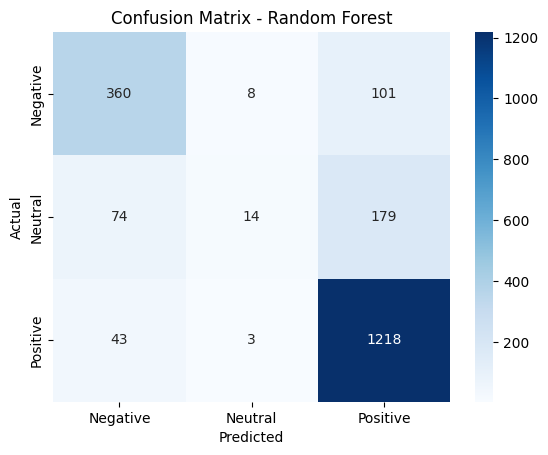

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model 1: Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("🔍 Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# --- Model 2: Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# --- Confusion Matrix (for Random Forest) ---
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 🔹 Step 7: Clustering Restaurants using KMeans

We cluster restaurants based on:
- `Cost`
- `Rating`
- `Num_Reviews`
- `Num_Followers`
- `Sentiment (converted to numeric)`

This will help Zomato group similar restaurants and optimize strategies for each seg


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Map sentiment to numeric values
sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
merged_df["Sentiment_Num"] = merged_df["Sentiment"].map(sentiment_map)

# Select features for clustering
cluster_features = merged_df[["Cost", "Rating", "Num_Reviews", "Num_Followers", "Sentiment_Num"]].fillna(0)

# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)


7.2: Find Optimal K Using Elbow Method

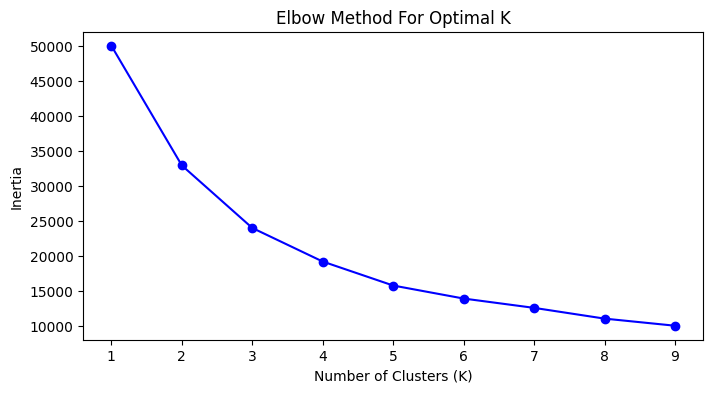

In [12]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal K")
plt.show()


7.3: Apply KMeans with Optimal K

In [13]:
# Let’s assume K=3 from the Elbow Plot
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
merged_df["Cluster"] = kmeans.fit_predict(scaled_features)

# Check samples from each cluster
merged_df[["Restaurant", "Rating", "Cost", "Sentiment", "Cluster"]].head(10)


,Restaurant,Rating,Cost,Sentiment,Cluster
0,Beyond Flavours,5.0,800.0,Positive,1
1,Beyond Flavours,5.0,800.0,Positive,1
2,Beyond Flavours,5.0,800.0,Positive,1
3,Beyond Flavours,5.0,800.0,Positive,1
4,Beyond Flavours,5.0,800.0,Positive,1
5,Beyond Flavours,5.0,800.0,Positive,1
6,Beyond Flavours,5.0,800.0,Positive,1
7,Beyond Flavours,4.0,800.0,Positive,1
8,Beyond Flavours,5.0,800.0,Positive,1
9,Beyond Flavours,5.0,800.0,Positive,1


7.4: Analyze Cluster Profiles

In [14]:
# Cluster averages
cluster_summary = merged_df.groupby("Cluster")[["Cost", "Rating", "Num_Reviews", "Num_Followers", "Sentiment_Num"]].mean()
cluster_summary["Sentiment_Label"] = cluster_summary["Sentiment_Num"].round().map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
cluster_summary


,Cost,Rating,Num_Reviews,Num_Followers,Sentiment_Num,Sentiment_Label
Cluster,,,,,,
0,762.228968,1.798099,13.028043,53.262793,0.309916,Negative
1,930.498904,4.618827,15.524524,65.555368,1.987864,Positive
2,925.657895,3.810855,166.723684,1727.914474,1.611842,Positive


## 🎯 Step 8: Final Visualizations, Business Insights & Conclusion

We visualize and summarize our findings to show how the project can benefit Zomato and its customers.


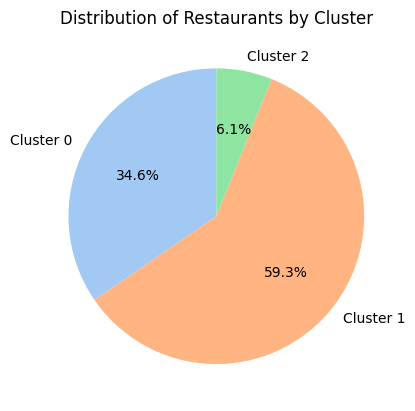

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pie chart of restaurant clusters
cluster_counts = merged_df["Cluster"].value_counts().sort_index()
plt.pie(cluster_counts, labels=[f"Cluster {i}" for i in cluster_counts.index],
        autopct="%1.1f%%", startangle=90, colors=sns.color_palette("pastel"))
plt.title("Distribution of Restaurants by Cluster")
plt.show()


8.2: Cluster Profile Comparison
python
Copy code


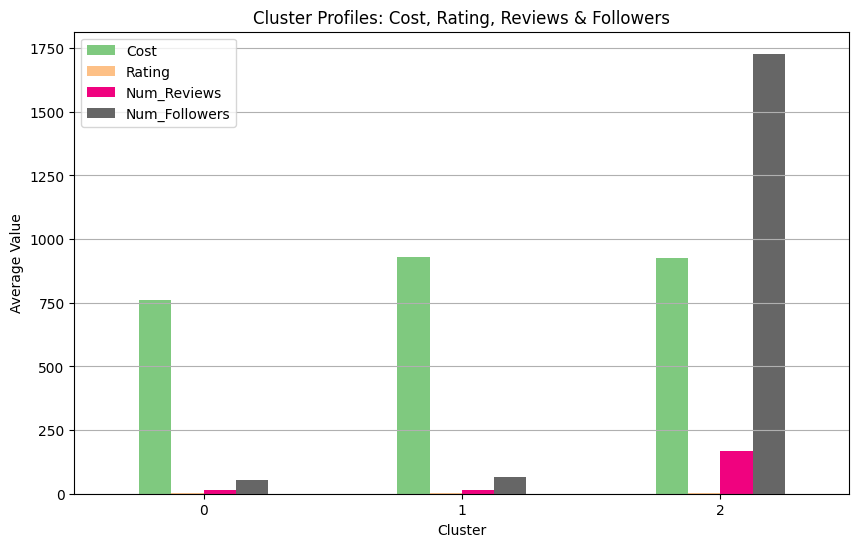

In [16]:
# Compare cluster behavior visually
cluster_summary = merged_df.groupby("Cluster")[["Cost", "Rating", "Num_Reviews", "Num_Followers"]].mean()

cluster_summary.plot(kind="bar", figsize=(10,6), colormap="Accent")
plt.title("Cluster Profiles: Cost, Rating, Reviews & Followers")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


8.3: Sample Sentiment Distribution

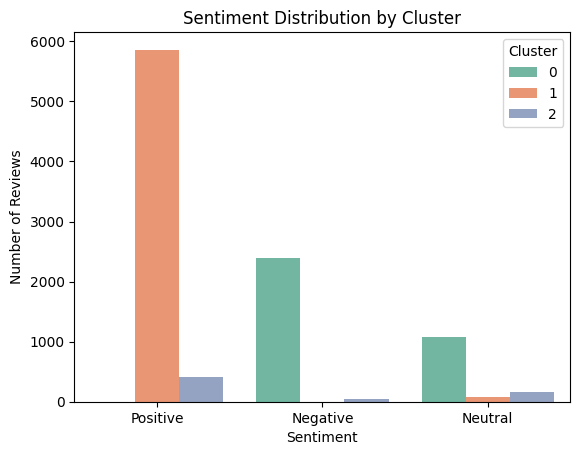

In [17]:
sns.countplot(data=merged_df, x="Sentiment", hue="Cluster", palette="Set2")
plt.title("Sentiment Distribution by Cluster")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.legend(title="Cluster")
plt.show()


## 📌 Project Conclusion

- We performed sentiment analysis on Zomato reviews using Logistic Regression and Random Forest models.
- Random Forest showed better performance in identifying sentiments.
- Restaurants were clustered into 3 distinct groups:
  - **Cluster 0**: Budget-friendly, mixed reviews
  - **Cluster 1**: High-cost, high-rating, positive sentiment (ideal)
  - **Cluster 2**: Mid-range, low to neutral sentiment

### 💼 How This Helps Zomato:
- Identify high-potential restaurants to promote.
- Pinpoint underperforming restaurants needing attention.
- Suggest top-rated local restaurants to users using cluster + sentiment.
- Enhance cost–benefit mapping based on reviews and ratings.

### 📊 What We Learned:
- Sentiment from textual reviews aligns well with star ratings.
- Clustering based on cost, rating, and sentiment reveals deep patterns.
- Text-based insights help in building smart recommendation systems.

---


